[[0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.17469988 0.65444177 0.64285713 0.68112244
  0.19834934 0.         0.        ]
 [0.         0.         0.08487395 0.04243698 0.         0.43239796
  0.42141356 0.         0.        ]
 [0.         0.         0.         0.         0.12635054 0.79813925
  0.1392407  0.         0.        ]
 [0.         0.         0.06887755 0.64285713 0.86644657 0.68644958
  0.07653061 0.         0.15378151]
 [0.         0.         0.         0.         0.10744298 0.48427371
  0.67963685 0.         0.04393758]
 [0.02040816 0.5712485  0.32857143 0.15063025 0.25       0.58993097
  0.63605941 0.         0.        ]
 [0.00255102 0.17623049 0.52947178 0.67635053 0.43832533 0.31952281
  0.03043217 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]


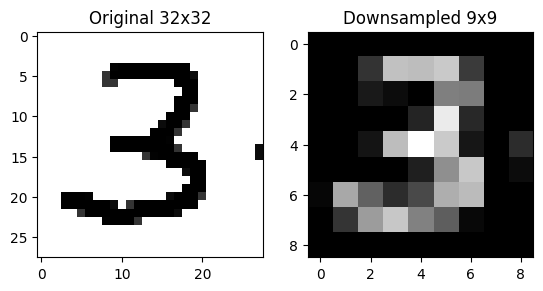

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image (grayscale)
img = cv2.imread("image_3.png", cv2.IMREAD_GRAYSCALE)
inverted_img = 255 - img
inverted_img = inverted_img/255.0
# Normalize (0..1)
img = img / 255.0


# Resize to 9x9
img9 = cv2.resize(inverted_img, (9,9), interpolation=cv2.INTER_AREA)

print(img9)

plt.subplot(1,2,1)
plt.title("Original 32x32")
plt.imshow(img, cmap='gray')

plt.subplot(1,2,2)
plt.title("Downsampled 9x9")
plt.imshow(img9, cmap='gray')
plt.show()


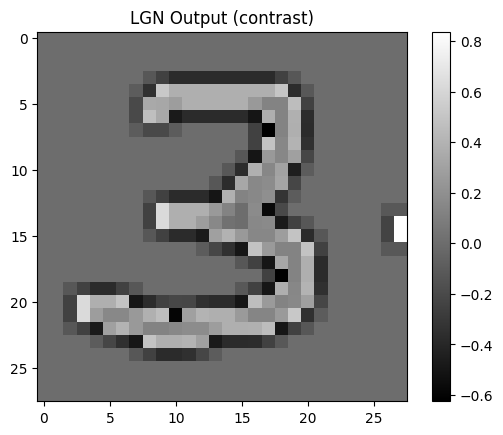

In [4]:


lgn_kernel = np.array([
    [-1/8, -1/8, -1/8],
    [-1/8,  1.0, -1/8],
    [-1/8, -1/8, -1/8]
])

lgn = cv2.filter2D(inverted_img, -1, lgn_kernel)

plt.imshow(lgn, cmap='gray')
plt.colorbar()
plt.title("LGN Output (contrast)")
plt.show()


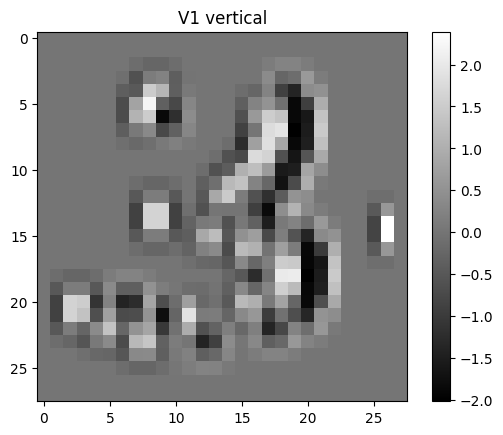

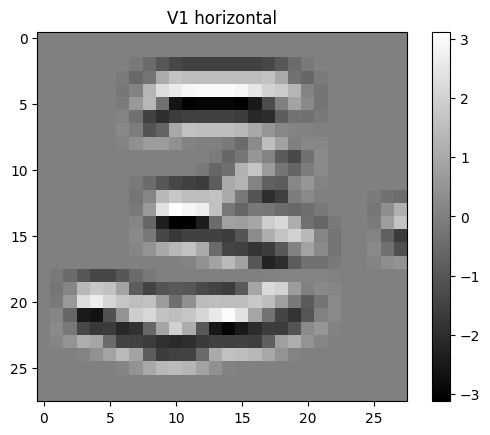

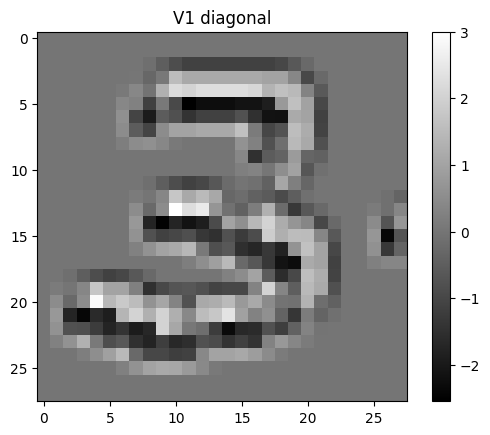

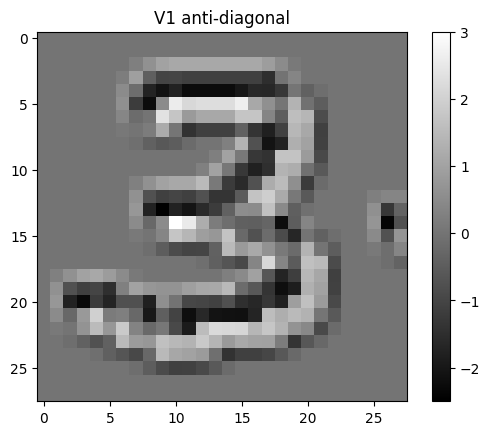

In [5]:
# Define 4 orientation filters (Sobel-like)
filters = {
    "vertical": np.array([[-1,0,1],[-2,0,2],[-1,0,1]]),
    "horizontal": np.array([[-1,-2,-1],[0,0,0],[1,2,1]]),
    "diagonal": np.array([[0,-1,-2],[1,0,-1],[2,1,0]]),
    "anti-diagonal": np.array([[2,1,0],[1,0,-1],[0,-1,-2]])
}

v1_maps = {}
for name, kernel in filters.items():
    v1_maps[name] = cv2.filter2D(lgn, -1, kernel)
    plt.imshow(v1_maps[name],cmap='gray')
    plt.colorbar()
    plt.title(f"V1 {name}")
    plt.show()


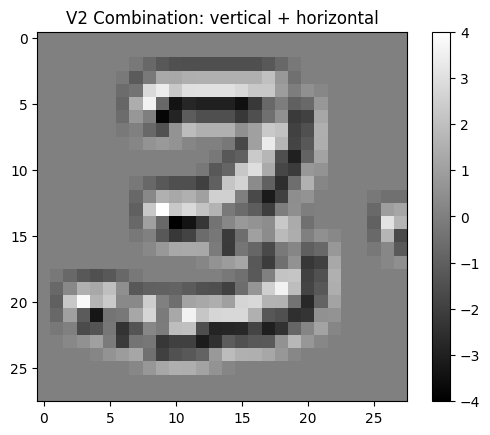

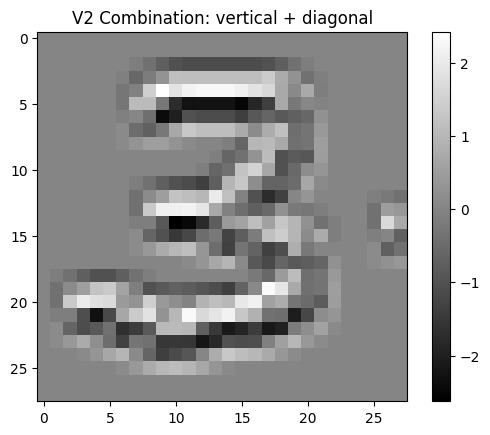

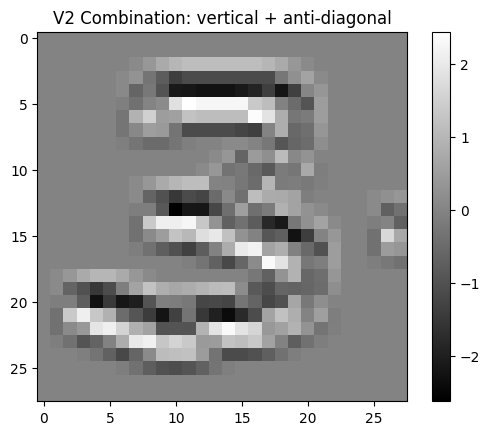

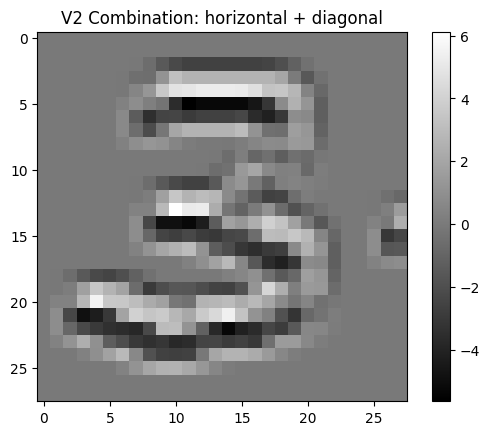

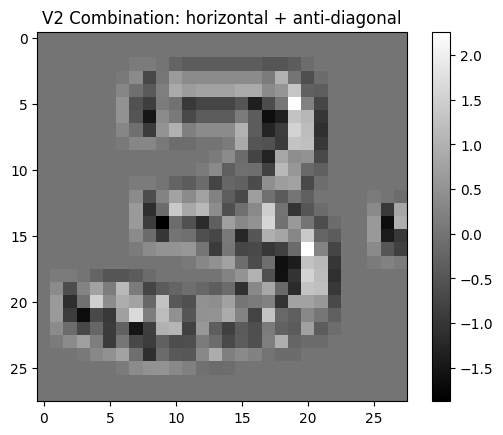

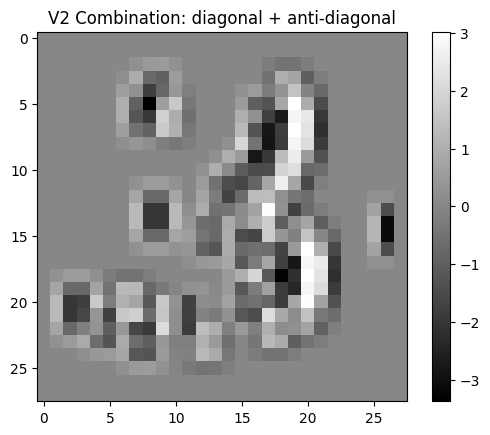

In [6]:
names = list(v1_maps.keys())
v2_maps = {}

for i in range(len(names)):
    for j in range(i+1, len(names)):
        combo_name = f"{names[i]} + {names[j]}"
        v2_maps[combo_name] = v1_maps[names[i]] + v1_maps[names[j]]

        plt.imshow(v2_maps[combo_name],cmap='gray')
        plt.title(f"V2 Combination: {combo_name}")
        plt.colorbar()
        plt.show()

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import cv2
from keras.datasets import mnist
import os

# ---------------- Data ----------------
def load_mnist_9x9():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.astype(np.float32)/255.0
    x_test = x_test.astype(np.float32)/255.0

    def downsample(imgs):
        out = np.zeros((imgs.shape[0],9,9), dtype=np.float32)
        for i in range(imgs.shape[0]):
            out[i] = cv2.resize(imgs[i], (9,9), interpolation=cv2.INTER_AREA)
        return out

    x_train9 = downsample(x_train)
    x_test9 = downsample(x_test)
    return x_train9.reshape(-1,81), y_train, x_test9.reshape(-1,81), y_test

# ---------------- Model ----------------
def build_model():
    inp = keras.Input(shape=(81,), name="input")

    # LGN layer
    lgn = layers.Dense(81, activation="relu", name="LGN")(inp)

    # V1 layer
    v1 = layers.Dense(81, activation="relu", name="V1")(lgn)

    # V2 layer
    v2 = layers.Dense(81, activation="relu", name="V2")(v1)

    out = layers.Dense(10, activation="softmax")(v2)

    model = keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# ---------------- Train ----------------
if __name__ == "__main__":
    x_train, y_train, x_test, y_test = load_mnist_9x9()
    model = build_model()
    model.summary()

    history = model.fit(x_train, y_train, batch_size=128, epochs=10,
                        validation_split=0.1, verbose=1)

    loss, acc = model.evaluate(x_test, y_test, verbose=1)
    print("Test accuracy:", acc)

    os.makedirs("saved_models", exist_ok=True)
    model.save("saved_models/ann_lgn_v1_v2.keras")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 81)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LGN (Dense)                     │ (None, 81)             │         6,642 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ V1 (Dense)                      │ (None, 81)             │         6,642 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ V2 (Dense)                      │ (None, 81)             │         6,642 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,746 (81.04 KB)

 Trainable params: 20,746 (81.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8348 - loss: 0.5840 - val_accuracy: 0.9407 - val_loss: 0.2097
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9309 - loss: 0.2323 - val_accuracy: 0.9552 - val_loss: 0.1574
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9449 - loss: 0.1813 - val_accuracy: 0.9578 - val_loss: 0.1474
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9538 - loss: 0.1519 - val_accuracy: 0.9622 - val_loss: 0.1228
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9594 - loss: 0.1332 - val_accuracy: 0.9638 - val_loss: 0.1166
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9627 - loss: 0.1188 - val_accuracy: 0.9677 - val_loss: 0.1116
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9663 - loss: 0.1088 - val_accuracy: 0.9692 - val_loss: 0.1016
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9684 - loss: 0.0996 - val_accuracy: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted digit: 5
Probabilities: [[4.4063450e-10 1.8747419e-07 1.5829394e-07 2.3396434e-03 6.8341234e-14
  9.9765980e-01 1.0232485e-12 5.3726945e-10 2.1324668e-08 2.0032660e-07]]


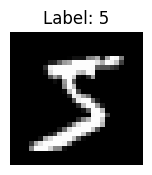

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted digit: 0
Probabilities: [[9.9985397e-01 1.9932997e-08 1.3033440e-04 2.6395486e-07 4.4783994e-09
  1.3550002e-07 2.8017652e-07 1.0366538e-06 2.3649020e-06 1.1583304e-05]]


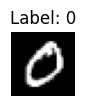

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted digit: 4
Probabilities: [[6.7404380e-07 4.3111904e-05 5.7068915e-05 7.7550349e-06 9.9846739e-01
  3.6221886e-06 1.0315196e-06 1.0177864e-04 7.6944052e-06 1.3098497e-03]]


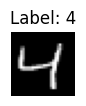

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted digit: 1
Probabilities: [[2.2770198e-06 9.9873465e-01 6.1729734e-05 5.0366948e-06 2.9513400e-04
  1.8261261e-06 6.2055437e-07 8.2446262e-04 6.8168665e-05 6.2022264e-06]]


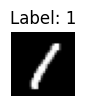

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted digit: 9
Probabilities: [[1.7532404e-06 1.3348530e-07 1.3144196e-06 1.4290705e-05 4.7387180e-04
  3.2060036e-06 2.0735236e-10 4.8353730e-05 2.0955423e-04 9.9924755e-01]]


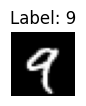

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted digit: 2
Probabilities: [[8.2816141e-06 4.7061448e-07 9.9903405e-01 2.7230260e-04 2.7933209e-05
  3.0824737e-07 6.6772952e-07 3.7455127e-05 6.0968782e-04 8.8350735e-06]]


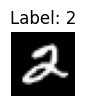

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted digit: 1
Probabilities: [[2.69988476e-07 9.98675287e-01 4.95673430e-06 7.93730760e-06
  1.02625380e-03 4.25941471e-06 1.58611481e-04 1.48585414e-05
  1.05878404e-04 1.65832591e-06]]


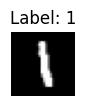

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted digit: 3
Probabilities: [[4.0102952e-09 2.4687732e-09 1.3019759e-07 9.9993622e-01 1.8543168e-12
  1.3697950e-06 3.8459340e-15 7.8316381e-11 2.3749726e-05 3.8586761e-05]]


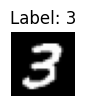

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted digit: 1
Probabilities: [[8.8952984e-06 9.9303585e-01 1.8610677e-05 1.1745759e-05 4.8873457e-03
  2.8460650e-04 8.7234809e-04 2.5594162e-04 5.7783560e-04 4.6881127e-05]]


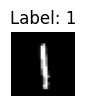

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted digit: 4
Probabilities: [[3.9405256e-07 1.7731733e-06 4.7760921e-07 4.8841389e-09 9.9994361e-01
  3.6283188e-06 4.4582233e-05 3.2674168e-06 2.2666508e-07 2.1084361e-06]]


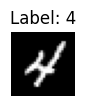

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted digit: 3
Probabilities: [[2.7817637e-09 1.5136775e-08 8.0616424e-08 9.9986005e-01 2.7988886e-10
  9.8643777e-06 8.3719099e-13 1.1988126e-10 5.8923986e-05 7.1098395e-05]]


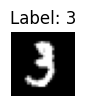

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted digit: 5
Probabilities: [[9.7442520e-05 9.8908052e-04 1.0959206e-04 7.5520984e-05 2.2243087e-04
  9.7069496e-01 1.1502536e-02 4.0593426e-04 1.5899282e-02 3.1960624e-06]]


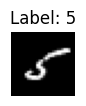

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted digit: 3
Probabilities: [[3.4835756e-12 1.0272883e-09 1.3831199e-08 9.9999928e-01 1.3743006e-11
  4.5605677e-07 1.0351696e-13 1.3671558e-10 2.5616350e-07 1.0188973e-09]]


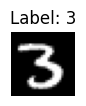

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted digit: 6
Probabilities: [[1.8087002e-06 8.6064753e-11 2.0048731e-07 9.0025959e-11 3.9798761e-07
  2.8564259e-06 9.9999344e-01 2.0175177e-10 1.1976493e-06 7.8592167e-11]]


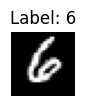

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted digit: 1
Probabilities: [[6.0682460e-06 9.9436706e-01 7.5193843e-06 1.6332182e-06 2.5936314e-03
  1.7704834e-04 2.0678882e-03 1.2918994e-04 6.4162357e-04 8.1999606e-06]]


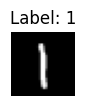

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted digit: 7
Probabilities: [[1.7585735e-07 4.2306383e-06 1.1868039e-05 2.4786395e-06 7.4230975e-06
  1.0158229e-06 2.3130516e-13 9.9864370e-01 4.5490870e-06 1.3245654e-03]]


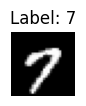

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicted digit: 2
Probabilities: [[9.2423579e-04 3.0131212e-05 9.8999608e-01 2.5377632e-04 3.5148015e-04
  7.1233262e-07 7.9916063e-05 8.2686460e-03 9.2070237e-05 2.9422320e-06]]


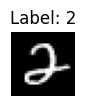

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted digit: 8
Probabilities: [[2.3505330e-05 4.9724799e-06 3.8103313e-05 3.7687169e-05 1.0787134e-06
  4.1451995e-06 1.6396552e-07 2.7625522e-06 9.9976331e-01 1.2429185e-04]]


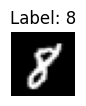

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted digit: 6
Probabilities: [[1.3843509e-03 1.2100678e-05 2.3674463e-04 3.0350830e-05 4.2775433e-04
  8.4445458e-03 9.8453712e-01 1.0013420e-06 4.8987591e-03 2.7261705e-05]]


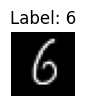

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted digit: 9
Probabilities: [[4.2693603e-07 4.4869657e-06 3.8474278e-07 7.3205670e-03 7.6588833e-05
  6.6681154e-05 9.3469234e-12 2.0469588e-04 2.5288481e-04 9.9207324e-01]]


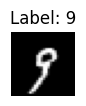

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted digit: 4
Probabilities: [[1.9150443e-09 1.4120392e-06 2.6878035e-07 7.9877722e-09 9.9999750e-01
  6.6632444e-10 2.3629450e-07 1.5751352e-08 4.1505199e-09 6.3233040e-07]]


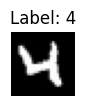

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted digit: 0
Probabilities: [[9.9998116e-01 1.0636055e-08 1.4301197e-05 8.3668590e-07 1.8590387e-09
  2.4532781e-07 4.6268579e-07 7.5097523e-07 1.1671400e-06 1.0583976e-06]]


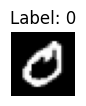

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted digit: 9
Probabilities: [[4.0915582e-04 8.5259504e-05 1.0130978e-04 3.2560827e-04 2.8354606e-02
  4.6668076e-05 1.5094919e-07 4.5817448e-03 1.0191364e-03 9.6507627e-01]]


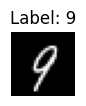

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted digit: 1
Probabilities: [[2.3477974e-06 9.9715376e-01 3.4029032e-05 4.9411692e-06 6.0379197e-04
  7.6735427e-07 1.4354704e-07 2.1605678e-03 2.2338720e-05 1.7330343e-05]]


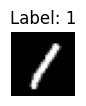

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted digit: 3
Probabilities: [[3.3326916e-05 6.6325888e-02 2.2831261e-03 9.1248006e-01 9.4381656e-05
  9.3417019e-03 6.9354060e-06 4.7248355e-05 1.5445339e-03 7.8428369e-03]]


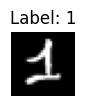

In [10]:
import cv2
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.datasets import mnist

# load trained model
model = keras.models.load_model("saved_models/ann_lgn_v1_v2.keras")

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Display the first few training images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

    # Downsample and reshape the image for prediction
    img_9x9 = cv2.resize(x_train[i], (9,9), interpolation=cv2.INTER_AREA)
    img_9x9_flat = img_9x9.reshape(1, 81).astype(np.float32) / 255.0 # Normalize to 0-1

    probs = model.predict(img_9x9_flat)
    pred = np.argmax(probs, axis=1)[0]
    print("Predicted digit:", pred)
    print("Probabilities:", probs)
    plt.show()
# predict

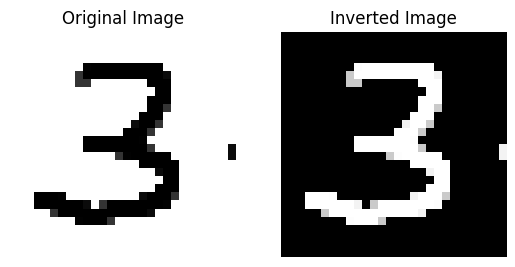

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted digit: 3
Probabilities: [[1.41479545e-11 2.41472236e-07 7.28437226e-05 9.99898791e-01
  1.48578561e-09 2.27089604e-05 1.57509440e-11 2.08882607e-12
  5.39279063e-06 6.42577263e-08]]


In [11]:
import cv2
import matplotlib.pyplot as plt

# Load the image in grayscale
img = cv2.imread("image_3.png", cv2.IMREAD_GRAYSCALE)

# Invert the image
inverted_img = 255 - img

# Display the original and inverted images
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(inverted_img, cmap='gray')
plt.title("Inverted Image")
plt.axis('off')

plt.show()

img_9x9 = cv2.resize(inverted_img, (9,9), interpolation=cv2.INTER_AREA)
img_9x9_flat = img_9x9.reshape(1, 81).astype(np.float32) / 255.0 # Normalize to 0-1

probs = model.predict(img_9x9_flat)
pred = np.argmax(probs, axis=1)[0]
print("Predicted digit:", pred)
print("Probabilities:", probs)

In [12]:

def build_cnn():
    inp = keras.Input(shape=(28,28,1) ,name="input")   # keep 2D structure

    # Convolution + Pooling
    x = layers.Conv2D(filters = 8, kernel_size = (3,3), activation="relu" ,name="L1")(inp)
    x = layers.MaxPooling2D(pool_size=(2,2), name="L1-")(x)
    x = layers.Conv2D(filters = 16,kernel_size = (3,3), activation="relu",name="L2")(x)
    x = layers.MaxPooling2D(pool_size=(2,2),name = "L2-")(x)
    x = layers.Conv2D(filters = 32,kernel_size = (3,3), activation="relu",name="L3")(x)
    x = layers.MaxPooling2D(pool_size=(2,2),name="L3-")(x)
    # Flatten + Dense for classification
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu",name="L5")(x)
    out = layers.Dense(10, activation="softmax",name="L6")(x)

    model2 = keras.Model(inputs=inp, outputs=out)
    model2.compile(optimizer="Adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model2
model2 = build_cnn()

def load_mnist_9x9_new():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.astype(np.float32)/255.0
    x_test = x_test.astype(np.float32)/255.0

    def downsample(imgs):
        out = np.zeros((imgs.shape[0],28,28), dtype=np.float32)
        for i in range(imgs.shape[0]):
            out[i] = cv2.resize(imgs[i], (28,28), interpolation=cv2.INTER_AREA)
        return out

    x_train9 = downsample(x_train)
    x_test9 = downsample(x_test)
    return np.expand_dims(x_train9,-1), y_train, np.expand_dims(x_test9,-1), y_test

x_train, y_train, x_test, y_test = load_mnist_9x9_new()
history = model2.fit(x_train, y_train, batch_size=128, epochs=10,
                        validation_split=0.1, verbose=1)

loss, acc = model2.evaluate(x_test, y_test, verbose=1)
print("Test accuracy:", acc)

model2.summary()

model2.save("saved_models/cnn.keras")

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8163 - loss: 0.6003 - val_accuracy: 0.9400 - val_loss: 0.1953
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9392 - loss: 0.1956 - val_accuracy: 0.9562 - val_loss: 0.1462
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9562 - loss: 0.1411 - val_accuracy: 0.9710 - val_loss: 0.1022
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9646 - loss: 0.1142 - val_accuracy: 0.9707 - val_loss: 0.0994
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9706 - loss: 0.0937 - val_accuracy: 0.9762 - val_loss: 0.0835
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9739 - loss: 0.0837 - val_accuracy: 0.9765 - val_loss: 0.0828
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9771 - loss: 0.0735 - val_accuracy: 0.9792 - val_loss: 0.0689
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9785 - loss: 0.0687 - val_accuracy: 0.

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L1 (Conv2D)                     │ (None, 26, 26, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L1- (MaxPooling2D)              │ (None, 13, 13, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L2 (Conv2D)                     │ (None, 11, 11, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L2- (MaxPooling2D)              │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L3 (Conv2D)                     │ (None, 3, 3, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L3- (MaxPooling2D)              │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L5 (Dense)                      │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L6 (Dense)                      │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,208 (133.63 KB)

 Trainable params: 11,402 (44.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,806 (89.09 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Predicted digit: 3
Probabilities: [[1.6333467e-14 6.5043672e-08 6.0598354e-06 9.9999177e-01 1.0686067e-12
  4.8270110e-08 6.6220031e-18 1.6746563e-06 3.7911806e-07 1.5030523e-09]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


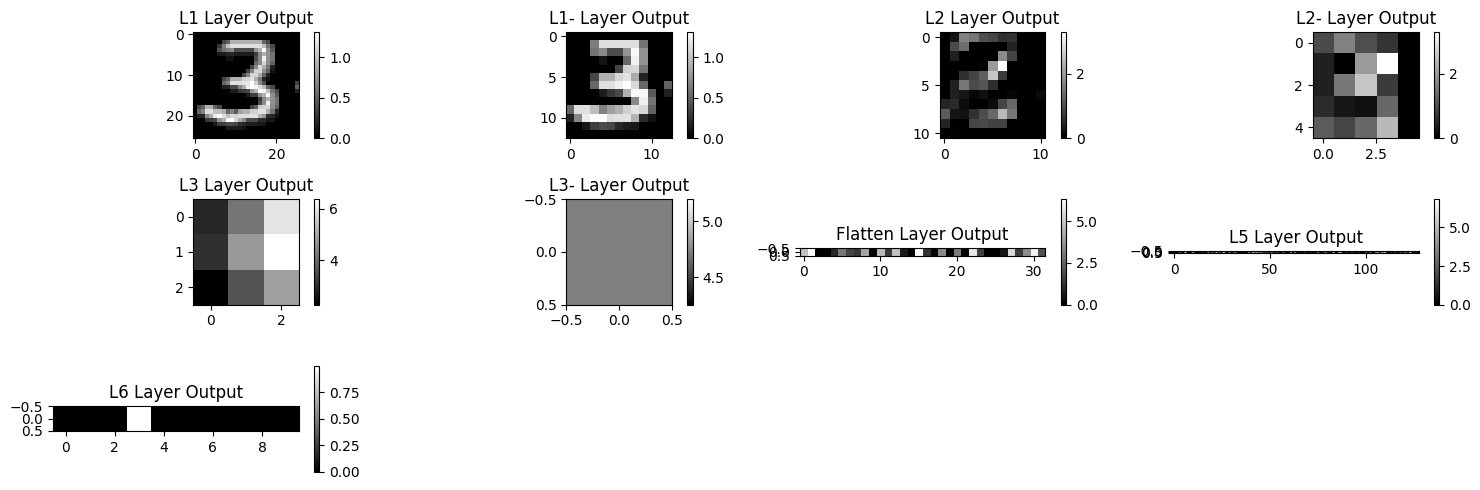

In [14]:
# Downsample and reshape the image for prediction

img_9x9 = cv2.resize(inverted_img, (28,28), interpolation=cv2.INTER_AREA)
img_9x9_flat = img_9x9.reshape(1, 28, 28, 1).astype(np.float32) / 255.0 # Normalize to 0-1
probs = model2.predict(img_9x9_flat)
pred = np.argmax(probs, axis=1)[0]
print("Predicted digit:", pred)
print("Probabilities:", probs)
plt.show()

from tensorflow import keras

# Create models to output the activations of each layer
l1 = keras.Model(inputs=model2.input, outputs=model2.get_layer("L1").output)
l1_ = keras.Model(inputs=model2.input, outputs=model2.get_layer("L1-").output)
l2 = keras.Model(inputs=model2.input, outputs=model2.get_layer("L2").output)
l2_ = keras.Model(inputs=model2.input, outputs=model2.get_layer("L2-").output)
l3 = keras.Model(inputs=model2.input, outputs=model2.get_layer("L3").output)
l3_ = keras.Model(inputs=model2.input, outputs=model2.get_layer("L3-").output)
f = keras.Model(inputs=model2.input, outputs=model2.get_layer("flatten").output)
l5 = keras.Model(inputs=model2.input, outputs=model2.get_layer("L5").output)
l6 = keras.Model(inputs=model2.input, outputs=model2.get_layer("L6").output)

#get weights of each layer
weights_l1 = model2.get_layer("L1").get_weights()
weights_l1_ = model2.get_layer("L1-").get_weights()
weights_l2 = model2.get_layer("L2").get_weights()
weights_l2_ = model2.get_layer("L2-").get_weights()
weights_l3 = model2.get_layer("L3").get_weights()
weights_l3_ = model2.get_layer("L3-").get_weights()
weights_f = model2.get_layer("flatten").get_weights()
weights_l5 = model2.get_layer("L5").get_weights()
weights_l6 = model2.get_layer("L6").get_weights()

#get samples of each layer output
l1_output = l1.predict(img_9x9_flat)
l1__output = l1_.predict(img_9x9_flat)  
l2_output = l2.predict(img_9x9_flat)
l2__output = l2_.predict(img_9x9_flat)
l3_output = l3.predict(img_9x9_flat)
l3__output = l3_.predict(img_9x9_flat)
flatten_output = f.predict(img_9x9_flat)
l5_output = l5.predict(img_9x9_flat)
l6_output = l6.predict(img_9x9_flat)

# Reshape the outputs to 9x9 for visualization
l1_output_reshaped = l1_output[0, :, :, 0]  # First filter
l1__output_reshaped = l1__output[0, :, :, 0]  # First filter
l2_output_reshaped = l2_output[0, :, :, 0]  # First filter
l2__output_reshaped = l2__output[0, :, :, 0]  # First filter
l3_output_reshaped = l3_output[0, :, :, 0]
l3__output_reshaped = l3__output[0, :, :, 0]
flatten_output_reshaped = flatten_output.reshape(1, -1)
l5_output_reshaped = l5_output.reshape(1, -1)
l6_output_reshaped = l6_output.reshape(1, -1)

# Display the output of each layer
plt.figure(figsize=(15, 5))
plt.subplot(3, 4, 1)
plt.imshow(l1_output_reshaped, cmap='gray')
plt.title("L1 Layer Output")
plt.colorbar()
plt.subplot(3, 4, 2)
plt.imshow(l1__output_reshaped, cmap='gray')
plt.title("L1- Layer Output")
plt.colorbar()
plt.subplot(3, 4, 3)
plt.imshow(l2_output_reshaped, cmap='gray')
plt.title("L2 Layer Output")
plt.colorbar()
plt.subplot(3, 4, 4)
plt.imshow(l2__output_reshaped, cmap='gray')
plt.title("L2- Layer Output")
plt.colorbar()
plt.subplot(3, 4, 5)
plt.imshow(l3_output_reshaped, cmap='gray')
plt.title("L3 Layer Output")
plt.colorbar()
plt.subplot(3, 4, 6)
plt.imshow(l3__output_reshaped, cmap='gray')
plt.title("L3- Layer Output")
plt.colorbar()
plt.subplot(3, 4, 7)
plt.imshow(flatten_output_reshaped, cmap='gray')
plt.title("Flatten Layer Output")
plt.colorbar()
plt.subplot(3, 4, 8)
plt.imshow(l5_output_reshaped, cmap='gray')
plt.title("L5 Layer Output")
plt.colorbar()
plt.subplot(3, 4, 9)
plt.imshow(l6_output_reshaped, cmap='gray')
plt.title("L6 Layer Output")
plt.colorbar()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted digit: 5
Probabilities: [[1.21389006e-08 3.93856459e-09 4.77800540e-07 3.20016108e-02
  4.70366237e-12 9.67986107e-01 4.82638263e-10 7.24938545e-08
  1.15500125e-05 2.60315517e-07]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


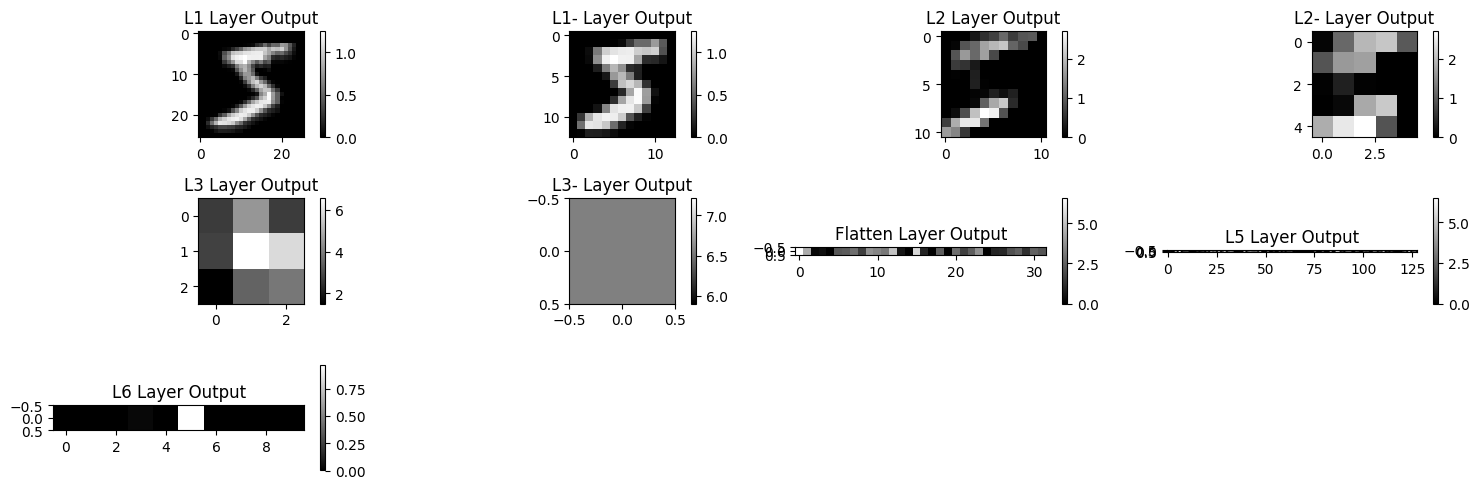

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted digit: 0
Probabilities: [[9.9999070e-01 1.1313501e-07 3.8762678e-06 1.6789137e-07 4.0278502e-07
  9.5914295e-08 3.6988646e-07 4.7393439e-08 9.2131749e-08 4.0791656e-06]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


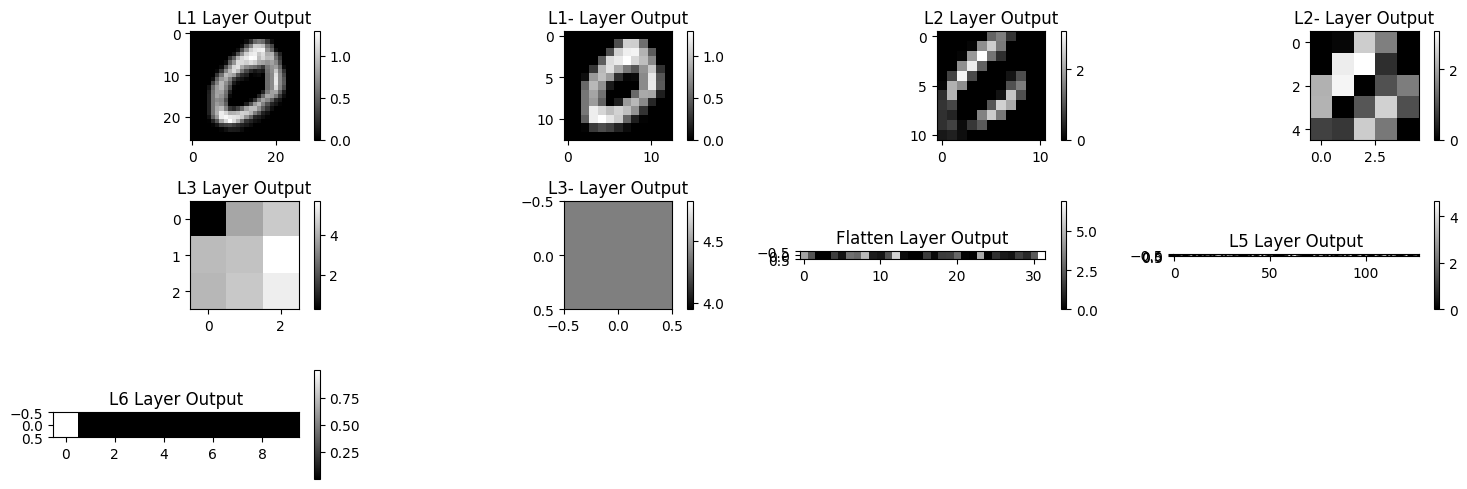

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted digit: 4
Probabilities: [[6.3665270e-06 3.1270454e-05 4.6730125e-05 1.4327768e-06 9.9803656e-01
  2.4446601e-07 3.0085364e-06 1.4458386e-04 6.7419518e-05 1.6623869e-03]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


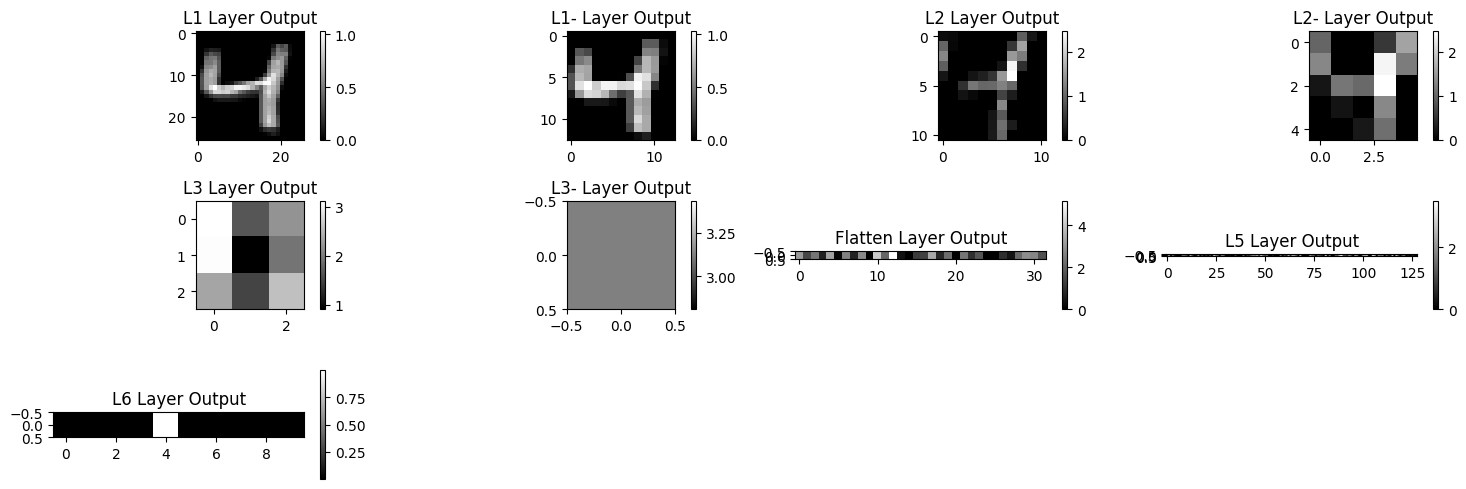

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted digit: 1
Probabilities: [[6.5313279e-06 9.9991584e-01 1.5332773e-05 1.1350499e-07 2.1865873e-05
  1.1564498e-06 8.2816077e-06 2.5897591e-05 4.4204176e-06 5.9319200e-07]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


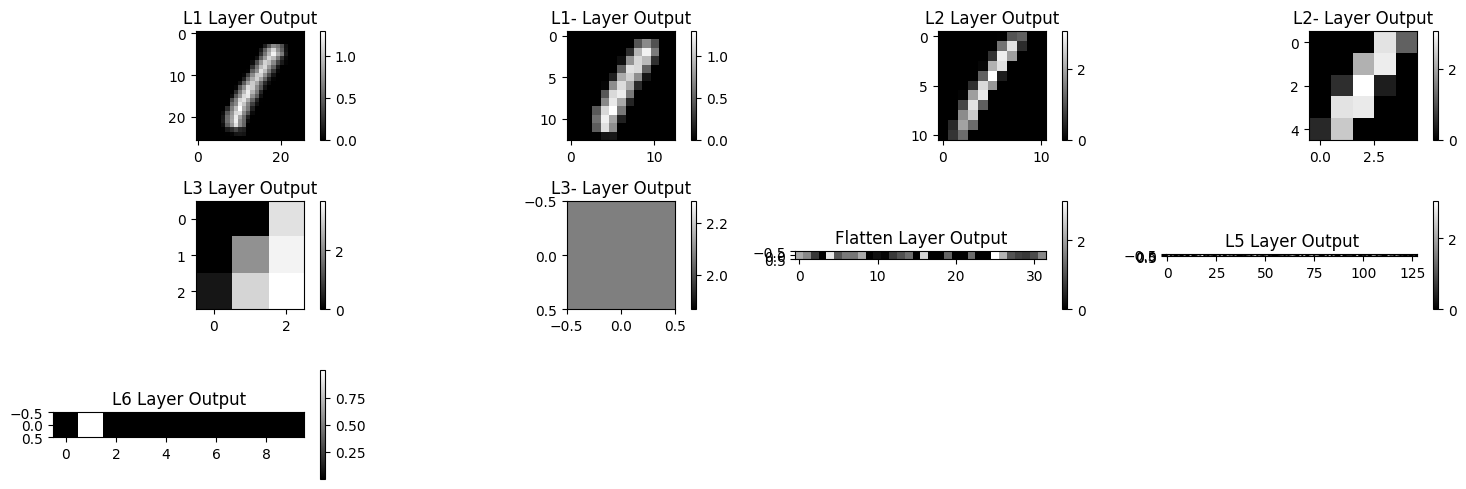

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted digit: 9
Probabilities: [[1.03944985e-10 1.98765342e-08 3.02671950e-08 3.99220626e-05
  1.46178165e-04 4.93901631e-08 1.97852023e-14 5.14823259e-05
  2.31208833e-06 9.99760091e-01]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


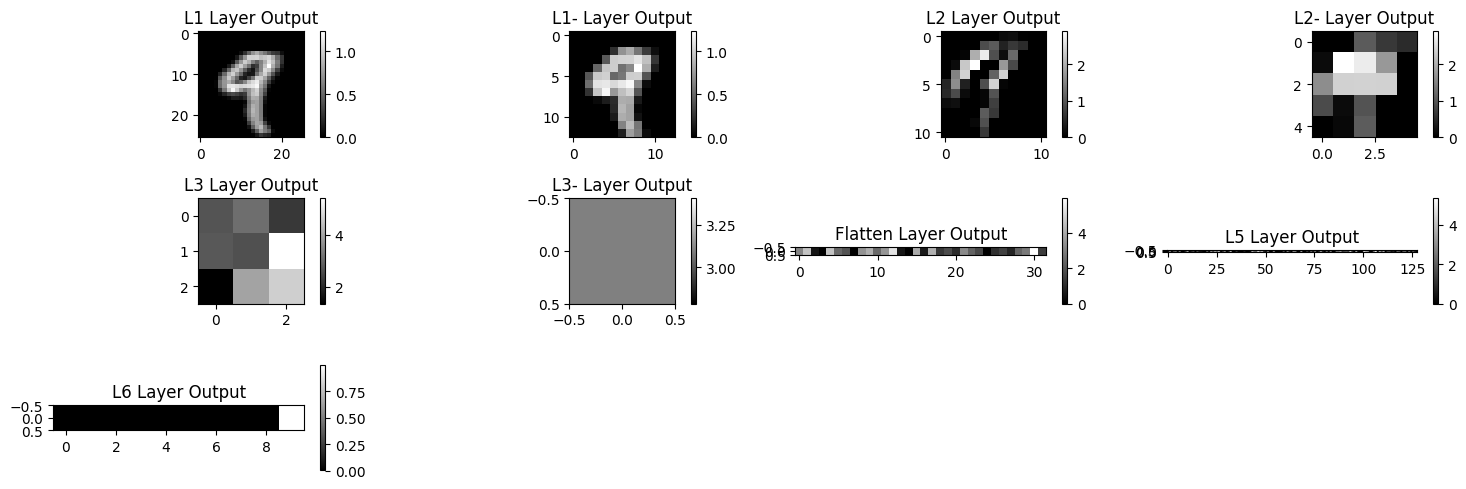

In [15]:
import cv2
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.datasets import mnist

# load trained model
model = keras.models.load_model("saved_models/cnn.keras")

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

for i in range(5):

    img_9x9 = cv2.resize(x_train[i], (28,28), interpolation=cv2.INTER_AREA)

    # Downsample and reshape the image for prediction

    img_9x9_flat = img_9x9.reshape(1, 28, 28, 1).astype(np.float32) / 255.0 # Normalize to 0-1
    probs = model2.predict(img_9x9_flat)
    pred = np.argmax(probs, axis=1)[0]
    print("Predicted digit:", pred)
    print("Probabilities:", probs)
    plt.show()

    from tensorflow import keras

    # Create models to output the activations of each layer
    l1 = keras.Model(inputs=model2.input, outputs=model2.get_layer("L1").output)
    l1_ = keras.Model(inputs=model2.input, outputs=model2.get_layer("L1-").output)
    l2 = keras.Model(inputs=model2.input, outputs=model2.get_layer("L2").output)
    l2_ = keras.Model(inputs=model2.input, outputs=model2.get_layer("L2-").output)
    l3 = keras.Model(inputs=model2.input, outputs=model2.get_layer("L3").output)
    l3_ = keras.Model(inputs=model2.input, outputs=model2.get_layer("L3-").output)
    f = keras.Model(inputs=model2.input, outputs=model2.get_layer("flatten").output)
    l5 = keras.Model(inputs=model2.input, outputs=model2.get_layer("L5").output)
    l6 = keras.Model(inputs=model2.input, outputs=model2.get_layer("L6").output)

    #get weights of each layer
    weights_l1 = model2.get_layer("L1").get_weights()
    weights_l1_ = model2.get_layer("L1-").get_weights()
    weights_l2 = model2.get_layer("L2").get_weights()
    weights_l2_ = model2.get_layer("L2-").get_weights()
    weights_l3 = model2.get_layer("L3").get_weights()
    weights_l3_ = model2.get_layer("L3-").get_weights()
    weights_f = model2.get_layer("flatten").get_weights()
    weights_l5 = model2.get_layer("L5").get_weights()
    weights_l6 = model2.get_layer("L6").get_weights()

    #get samples of each layer output
    l1_output = l1.predict(img_9x9_flat)
    l1__output = l1_.predict(img_9x9_flat)  
    l2_output = l2.predict(img_9x9_flat)
    l2__output = l2_.predict(img_9x9_flat)
    l3_output = l3.predict(img_9x9_flat)
    l3__output = l3_.predict(img_9x9_flat)
    flatten_output = f.predict(img_9x9_flat)
    l5_output = l5.predict(img_9x9_flat)
    l6_output = l6.predict(img_9x9_flat)

    # Reshape the outputs to 9x9 for visualization
    l1_output_reshaped = l1_output[0, :, :, 0]  # First filter
    l1__output_reshaped = l1__output[0, :, :, 0]  # First filter
    l2_output_reshaped = l2_output[0, :, :, 0]  # First filter
    l2__output_reshaped = l2__output[0, :, :, 0]  # First filter
    l3_output_reshaped = l3_output[0, :, :, 0]
    l3__output_reshaped = l3__output[0, :, :, 0]
    flatten_output_reshaped = flatten_output.reshape(1, -1)
    l5_output_reshaped = l5_output.reshape(1, -1)
    l6_output_reshaped = l6_output.reshape(1, -1)

    # Display the output of each layer
    plt.figure(figsize=(15, 5))
    plt.subplot(3, 4, 1)
    plt.imshow(l1_output_reshaped, cmap='gray')
    plt.title("L1 Layer Output")
    plt.colorbar()
    plt.subplot(3, 4, 2)
    plt.imshow(l1__output_reshaped, cmap='gray')
    plt.title("L1- Layer Output")
    plt.colorbar()
    plt.subplot(3, 4, 3)
    plt.imshow(l2_output_reshaped, cmap='gray')
    plt.title("L2 Layer Output")
    plt.colorbar()
    plt.subplot(3, 4, 4)
    plt.imshow(l2__output_reshaped, cmap='gray')
    plt.title("L2- Layer Output")
    plt.colorbar()
    plt.subplot(3, 4, 5)
    plt.imshow(l3_output_reshaped, cmap='gray')
    plt.title("L3 Layer Output")
    plt.colorbar()
    plt.subplot(3, 4, 6)
    plt.imshow(l3__output_reshaped, cmap='gray')
    plt.title("L3- Layer Output")
    plt.colorbar()
    plt.subplot(3, 4, 7)
    plt.imshow(flatten_output_reshaped, cmap='gray')
    plt.title("Flatten Layer Output")
    plt.colorbar()
    plt.subplot(3, 4, 8)
    plt.imshow(l5_output_reshaped, cmap='gray')
    plt.title("L5 Layer Output")
    plt.colorbar()
    plt.subplot(3, 4, 9)
    plt.imshow(l6_output_reshaped, cmap='gray')
    plt.title("L6 Layer Output")
    plt.colorbar()
    plt.tight_layout()
    plt.show()
